In [1]:
import random
import warnings

import pandas as pd
from IPython.display import HTML, Markdown, display
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from utility import CASE, METHO, VALID, check_job_title, clean_skills, init_jobs

In [2]:
warnings.filterwarnings("ignore")

In [3]:
HTML(
    """
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

# Introduction

job mismatch dilemma intro

# Statement of the Problem

The job skill mismatch dilemma presents a significant challenge, causing inefficiencies in hiring processes. To mitigate this, a streamlined solution is needed to recommend skills for enhancing applicant hirability and enabling employers to efficiently select and rank candidates with the help of frequent itemset mining (fim) association rules.

# Dataset Overview

The LinkedIn dataset contains 12,217 job postings focusing exclusively on tech job opportunities. Each entry in the dataset offers detailed information, including job titles, company profiles, geographical locations, and relevant search parameters.

The LinkedIn dataset, extracted from Kaggle, comprises three distinct CSV files: job_postings.csv, job_skills.csv, and job_summary.csv. The three files were merged using the "job_link" column.

There are no null or NaN rows in the dataset, hence no data imputation or rows were dropped.

In [4]:
merged_df = init_jobs()
merged_df.info()

12217

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12217 non-null  object
 1   job_summary          12217 non-null  object
 2   last_processed_time  12217 non-null  object
 3   last_status          12217 non-null  object
 4   got_summary          12217 non-null  object
 5   got_ner              12217 non-null  object
 6   is_being_worked      12217 non-null  object
 7   job_title            12217 non-null  object
 8   company              12217 non-null  object
 9   job_location         12216 non-null  object
 10  first_seen           12217 non-null  object
 11  search_city          12217 non-null  object
 12  search_country       12217 non-null  object
 13  search_position      12217 non-null  object
 14  job_level            12217 non-null  object
 15  job_type             12217 non-null  object
 16  job_

After merging the dataframes, the following columns were used:
1. **job_link** - actual job link of the job posting
2. **job_title** - full job title of the job opening (Ex. Senior Data Warehouse Developer/ Architect)
3. **job_skills** - list of skills needed for the job opening

To standardize the job titles, the team implemented a categorization system for common roles like 'Data Scientist', 'Data Analyst', etc. 

Examples:
1. 'Senior Machine Learning Engineer' will be categorized as 'Machine Learning Engineer'.
2. 'Staff Data Scientist, Financial Strategy' will be categorized as 'Data Scientist'.
3. 'Senior ETL Data Warehouse Specialist' will be categorized as 'Data Engineer'.

note: sample job_titles are present in our actual database 

This categorization process also disregarded job level indicators present in the titles, such as 'senior', 'junior', or 'associate'. Furthermore, given the higher number of 'Mid senior' roles compared to 'Associate' positions, the team opted not to differentiate between various job levels.


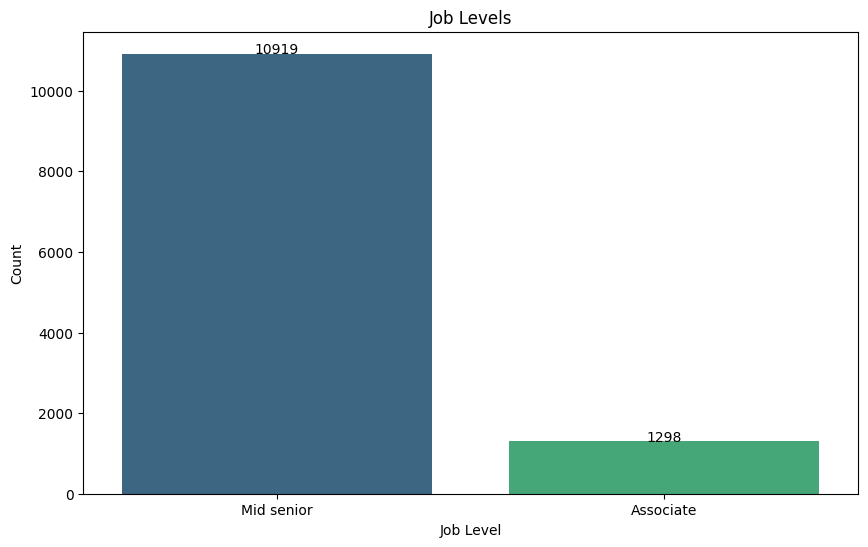

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

job_level_counts = merged_df['job_level'].value_counts().reset_index()
job_level_counts.columns = ['Job Level', 'Count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=job_level_counts, x='Job Level', y='Count', palette='viridis')
plt.title('Job Levels')
plt.xlabel('Job Level')
plt.ylabel('Count')

# Annotate bars with counts
for index, row in job_level_counts.iterrows():
    ax.text(row.name, row['Count']+0.2, row['Count'], color='black', ha="center")

plt.show()


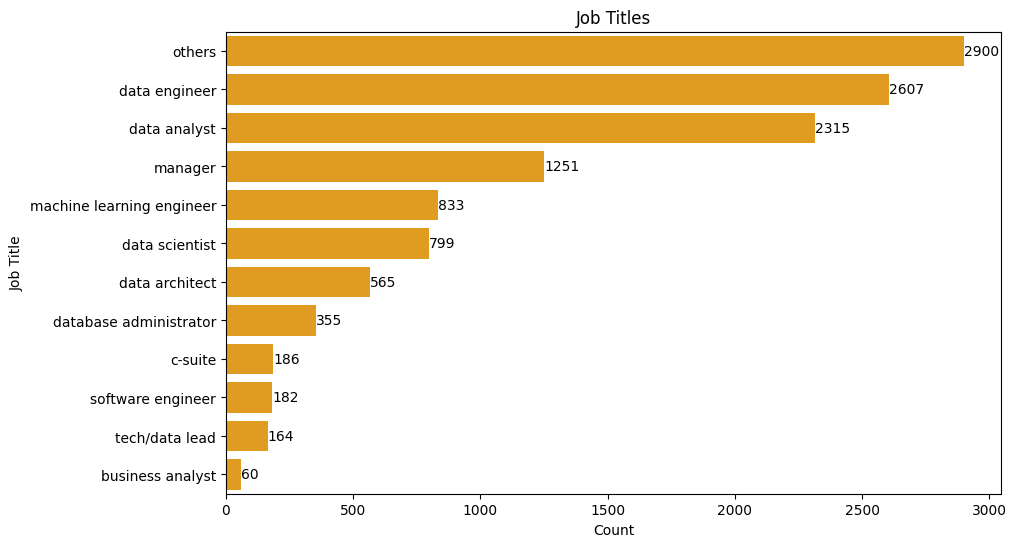

In [6]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
job_title_counts = merged_df['job_title_new'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=merged_df, y='job_title_new', order=job_title_counts.index, color='orange')
plt.title('Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')

for i, count in enumerate(job_title_counts):
    ax.text(count, i, str(count), ha='left', va='center')

plt.show()


An overview of the key skills within our database

In [7]:
merged_df["job_skills_"] = merged_df["job_skills"].apply(clean_skills)
list_of_lists = merged_df["job_skills_"].to_list()
list_of_words = [item for sublist in list_of_lists for item in sublist]

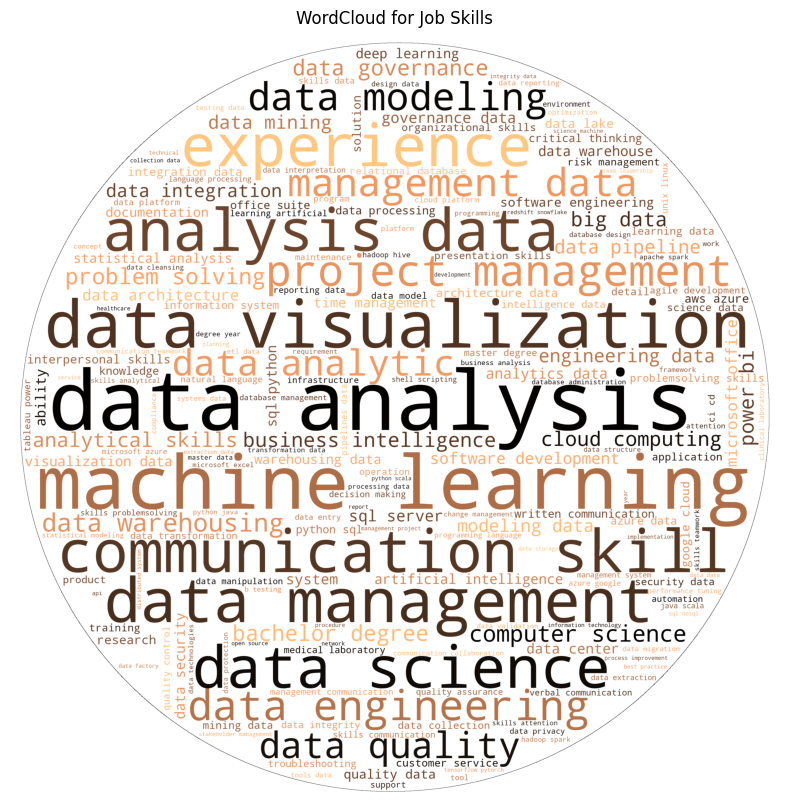

In [9]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import numpy as np

mask = np.array(Image.open('images_copy/circle_PNG14.png'))
colors = ImageColorGenerator(mask)
# display(colors)
# cat_mask = rgb2gray(mpimg.imread('images/alice.png'))
# display(cat_mask)
wordcloud = WordCloud(
    mask=mask,
    stopwords=set(STOPWORDS),
    contour_width=0.1,
    contour_color='black',
    min_font_size=3,
    background_color='white',
    colormap='copper'
).generate(' '.join(list_of_words))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Job Skills")
plt.show()

# Methodology

## Merged Dataframe

Prepared input CSVs to a merged dataframe for processing

In [22]:
merged_df[merged_df['job_title_new']== 'data engineer']

,job_link,job_summary,last_processed_time,last_status,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,job_title_new,job_skills_
2,https://www.linkedin.com/jobs/view/senior-etl-...,"Location: New York City, NY\r\nPosition Summar...",2024-01-21 08:08:31.941595+00,Finished NER,t,t,f,Senior ETL Data Warehouse Specialist,Adame Services LLC,"New York, NY",1/14/2024,Middletown,United States,Technical Support Specialist,Associate,Onsite,"ETL, Data Integration, Data Transformation, Da...",data engineer,"[etl, data integration, data transformation, d..."
4,https://www.linkedin.com/jobs/view/lead-data-e...,Dice is the leading career destination for tec...,2024-01-21 08:08:58.312124+00,Finished NER,t,t,f,Lead Data Engineer,Dice,"Plano, TX",1/14/2024,McKinney,United States,Maintenance Data Analyst,Mid senior,Onsite,"Java, Scala, Python, RDBMS, NoSQL, Redshift, S...",data engineer,"[java, scala, python, rdbms, nosql, redshift, ..."
5,https://www.linkedin.com/jobs/view/senior-data...,Department\r\nF&A ITS - Business Intelligence ...,2024-01-21 07:14:11.378097+00,Finished NER,t,t,f,Senior Data Engineer,University of Chicago,"Chicago, IL",1/14/2024,East Chicago,United States,Data Base Administrator,Mid senior,Onsite,"Data Warehouse (DW), Extract/Transform/Load (E...",data engineer,"[data warehouse (dw), extract/transform/load (..."
7,https://www.linkedin.com/jobs/view/principal-a...,Company Description\r\nJobs for Humanity is pa...,2024-01-21 07:39:58.478064+00,Finished NER,t,t,f,"Principal Associate, Data Loss Prevention (DLP...",Jobs for Humanity,"Scranton, PA",1/14/2024,Nanticoke,United States,Architect,Mid senior,Onsite,"Data Loss Prevention (DLP), Cybersecurity, Web...",data engineer,"[data loss prevention (dlp), cybersecurity, we..."
15,https://uk.linkedin.com/jobs/view/data-enginee...,Join Our Team as a Data Engineering Manager!\r...,2024-01-21 07:15:37.821778+00,Finished NER,t,t,f,Data Engineer Manager,Energy Jobline,"Wolverhampton, England, United Kingdom",1/14/2024,Telford,United Kingdom,Agricultural-Research Engineer,Mid senior,Onsite,"Data Engineering, Data Analytics, Data Warehou...",data engineer,"[data engineering, data analytics, data wareho..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12196,https://ca.linkedin.com/jobs/view/ims-data-spe...,Position Description\r\nMission:\r\nThe Data S...,2024-01-21 07:18:38.795558+00,Finished NER,t,t,f,IMS Data Specialist - OSISoft Pi Historian,CGI,"Toronto, Ontario, Canada",1/16/2024,North York,Canada,Historian,Mid senior,Onsite,"Asset frameworks, Event frame templates, Attri...",data engineer,"[asset frameworks, event frame templates, attr..."
12197,https://www.linkedin.com/jobs/view/senior-data...,This is for a client of Recruiting from Scratc...,2024-01-21 07:26:19.12456+00,Finished NER,t,t,f,"Senior Data Engineer, Public Company",Recruiting from Scratch,"Wichita, KS",1/14/2024,Wichita,United States,Computer Operator,Mid senior,Onsite,"Data Engineering, Business Intelligence, Data ...",data engineer,"[data engineering, business intelligence, data..."
12203,https://www.linkedin.com/jobs/view/lead-data-e...,Company Description\r\nJobs for Humanity is pa...,2024-01-21 07:27:12.53352+00,Finished NER,t,t,f,"Lead Data Engineer, (Python, Java or Scala)",Jobs for Humanity,"Charlottesville, VA",1/14/2024,Waynesboro,United States,Agricultural-Research Engineer,Mid senior,Onsite,"Python, Java, Scala, Data Modeling, Machine Le...",data engineer,"[python, java, scala, data modeling, machine l..."
12207,https://uk.linkedin.com/jobs/view/senior-lead-...,Description\r\nAs a lead team member of the Da...,2024-01-21 07:29:06.068335+00,Finished NER,t,t,f,Senior/Lead Data Software Engineer,EPAM Systems,"London, England, United Kingdom",1/16/2024,Slough,United Kingdom,Loading-Machine Tool-Setter,Associate,Onsite,"Data Platform Engineering, Data Products, Data...",data e

In [ ]:
merged_df = init_jobs()

## Jobs binning

Binning jobs for selection later when cases are created where one person wants to transition into one of the binned roles.

In [ ]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
merged_df["job_title_new"].value_counts()

create new column `job_skills_` list of skills for the job

In [ ]:
merged_df["job_skills_"] = merged_df["job_skills"].apply(clean_skills)

Bin job titles into these job titles:
- data engineer 
- data scientist 
- data analyst 
- business analyst 
- database engineer 
- database administrator 
- data architect 
- machine learning/mlops engineer 
- software engineer 
- tech lead 

## Base Transaction Database

This will be the base database for filtering later when we filter by job title.

In [ ]:
merged_df[["job_link", "job_title_new", "job_skills_"]].head(6)

## Using FIM to recommend skills to add to a person

In this project we'll be using FIM to recommend skills to a person given a base skillset. To recommend we will first create the frequent itemset using `fpgrowth` in `mlexted` library using `mlextend.fpgrowth` function and then getting associated association rules using `mlexted.association_rules` function. From the association rules, we will filter the antecedents based on the input base skills, order the rules by list and get top consequents that it unique and not already in the input base skills. We will then define a validation process below.

\begin{align}
\text{Probability to get job} &= \frac{\text{no. skills matched}}{\text{no. skills required by job}} \\
\text{Hirability} &= \text{Probability of getting any jobs in the current DB} = \frac{\sum_{i=1}^{n}\text{Probability to get job}_i}{\text{total transactions in DB (n)}}
\end{align}

We'll quote the above metric as $Hirability$ based on what skills you have. $Hirability$ will be then compared for:
- Base Case (base skills only)
- Stochastic Case (add n randomly sourced skills)
- FIM Case (add n skills with most lift in the association rules)

In this project we'll be using Base Case as the baseline. Stochastic case as the "usual" method of expanding skills (in real life this is not entirely true but we'll use this as some kind of a PCC metric that will define your hirability by adding random skills). Finally, FIM case will be the alternative case. We will then check with the sample cases below the performance of all 3 based on their computed $Hirability$.

In [ ]:
def skill_fim(merged_df, job_tit, support):
    print(f"Wanting to transition to {job_tit}...")
    db = merged_df[merged_df["job_title_new"] == job_tit]
    dataset = db["job_skills_"].to_list()
    print(f"Size of DB: {len(dataset)}")
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)

    rules = association_rules(frequent_itemsets, metric="lift")
    rules = rules[rules["antecedents"].isin(frequent_itemsets["itemsets"].to_list())]
    rules["a_cnt"] = rules["antecedents"].apply(len)
    rules["c_cnt"] = rules["consequents"].apply(len)
    rules = rules.sort_values(by=["c_cnt", "lift", "support"], ascending=False)
    return rules, frequent_itemsets, db

In [ ]:
def get_skills_probability(job_database, skills_to_match):
    job_database["acceptance_prob"] = job_database["job_skills_"].apply(
        lambda x: len(skills_to_match.intersection(x)) / len(x)
    )
    prob = round((job_database["acceptance_prob"].sum() / len(job_database)) * 100, 4)
    return prob, job_database["acceptance_prob"].sum(), len(job_database)

In [ ]:
def test_fim(merged_df, job_tit, supp, base_skills, no_skills_to_add):
    c_rules, c_fi, c_db = skill_fim(merged_df, job_tit, supp)
    display(Markdown(f"{job_tit.upper()} frequent itemset:"))
    display(c_fi)
    display(Markdown("Search frequent itemset if base skill in it:"))
    display(c_fi[c_fi["itemsets"] <= base_skills])
    display(
        Markdown(
            METHO.format(
                base_skills,
                base_skills,
                no_skills_to_add,
                base_skills,
                no_skills_to_add,
            )
        )
    )

    display(Markdown("### Base Case"))
    prob, job_cnt, job_total = get_skills_probability(c_db, base_skills)
    print(
        CASE.format(
            base_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    base = prob

    display(Markdown("### Stochastic Case"))
    display(
        Markdown(
            f"Get hirability when {no_skills_to_add} random skills are added to base case, have 100 iterations and get the average"
        )
    )
    prob_list = []
    for i in range(100):
        choice = set(
            [item for sublist in c_db["job_skills_"].tolist() for item in sublist]
        )
        random_skill = random.sample(list(choice), no_skills_to_add)
        skills_to_match = base_skills.union(random_skill)
        prob_list.append(get_skills_probability(c_db, skills_to_match)[0])
    average = sum(prob_list) / len(prob_list)
    print(
        CASE.format(
            f"{base_skills} plus {no_skills_to_add} random skills, 100 iterations then get average",
            round(average, 4),
            round(round(average * len(c_db) / 100)),
            len(c_db),
            len(c_db),
            job_tit,
            round(round(average * len(c_db) / 100)),
        )
    )
    stochastic = average

    display(Markdown("### FIM Case"))
    display(
        Markdown(
            f"From the association rules above get top {no_skills_to_add} skills consequents with highest lift and add to skills"
        )
    )
    most_lift = c_rules[
        c_rules["antecedents"].apply(lambda rules: rules <= base_skills)
    ].sort_values(by=["lift"], ascending=False)
    display(most_lift)
    consequents = [list(fs) for fs in most_lift["consequents"].to_list()]
    fim_skills = []
    consequents_ = [item for sublist in consequents for item in sublist]
    [fim_skills.append(i) for i in consequents_ if i not in fim_skills]
    fim_skills = [i for i in fim_skills if i not in base_skills][:no_skills_to_add]
    fim_skills = base_skills.union(fim_skills)
    prob, job_cnt, job_total = get_skills_probability(c_db, fim_skills)
    print(
        CASE.format(
            fim_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    fim = prob

    display(Markdown("### Validation"))
    display(Markdown(VALID.format(round(base, 4), round(stochastic, 4), round(fim, 4))))

# Results and Discussion

## Case 1 - Fresh Grad to Data Scientist
with basic python and numpy knowledge, wants to be Data scientist

In [ ]:
base_skills = {"python", "pandas", "numpy"}
test_fim(
    merged_df=merged_df,
    job_tit="data scientist",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
)

## Case 2 - Data Engineer to Tech Lead

In [ ]:
base_skills = {"python", "spark", "hadoop", "sql"}
test_fim(
    merged_df=merged_df,
    job_tit="tech/data lead",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
)

# Conclusion

# Recommendation

# References